In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Flatten, TimeDistributed, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from glob import glob
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Activation, Multiply
from tensorflow.keras import backend as K
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.utils import Sequence

In [3]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [4]:
from tensorflow.keras.layers import Layer, Dense, Activation, Multiply, Lambda
import tensorflow.keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape: (batch_size, timesteps, features)
        self.W = self.add_weight(name='att_weight', 
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias', 
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.V = self.add_weight(name='att_var', 
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # inputs: (batch_size, timesteps, features)
        # Score calculation for each time step
        score = K.tanh(K.dot(inputs, self.W) + self.b)  # (batch_size, timesteps, features)
        score = K.dot(score, self.V)  # (batch_size, timesteps, 1)
        attention_weights = K.softmax(score, axis=1)  # (batch_size, timesteps, 1)
        
        # Multiply each time step by its attention weight
        context_vector = inputs * attention_weights  # (batch_size, timesteps, features)
        context_vector = K.sum(context_vector, axis=1)   # (batch_size, features)
        return context_vector

# Convenience function to use the layer
def attention_layer(inputs):
    return AttentionLayer()(inputs)


In [5]:
def build_model(input_shape=(299, 299, 9)):
    """
    Builds an improved Xception-based spatial feature extractor and a Bidirectional LSTM
    for temporal analysis with pooling layers and batch normalization.
    """
    print("Building improved model...")

    # Spatial Feature Extractor
    base_model = Xception(include_top=False, weights=None, input_shape=input_shape)

    # Use GlobalAveragePooling2D to aggregate the spatial features.
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    spatial_model = Model(inputs=base_model.input, outputs=x, name="spatial_model")

    # Temporal Analysis with LSTM (Improved)
    lstm_input = Input(shape=(None, 512), name="lstm_input")

    # First LSTM remains the same:
    lstm_out = Bidirectional(LSTM(256, return_sequences=True, dropout=0.4, recurrent_dropout=0.2))(lstm_input)
    # Change the second LSTM to output sequences (i.e., 3D tensor)
    lstm_out = Bidirectional(LSTM(128, return_sequences=True, dropout=0.4))(lstm_out)

    # Now attention_layer receives a 3D tensor as expected
    attn_out = attention_layer(lstm_out)
    attn_out = BatchNormalization()(attn_out)

    output = Dense(1, activation='sigmoid')(attn_out)
    temporal_model = Model(inputs=lstm_input, outputs=output, name="temporal_model")

    print("Improved model built successfully.")
    return spatial_model, temporal_model


def train_model(spatial_model, temporal_model, x_train, y_train, x_test, y_test, epochs=100, batch_size=32):
    """Trains the model with improved training strategy."""
    print("Extracting features from Xception (Spatial Model)...")

    # Extract features from Xception
    x_train_features = spatial_model.predict(x_train)
    x_test_features = spatial_model.predict(x_test)

    # Reshape for LSTM
    x_train_features = np.expand_dims(x_train_features, axis=1)
    x_test_features = np.expand_dims(x_test_features, axis=1)

    # Compile the LSTM (Temporal Model)
    temporal_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    print("Training Improved Temporal Model (LSTM)...")

    # Callbacks
    model_checkpoint = ModelCheckpoint(
        filepath="best_model.h5",
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        verbose=1
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

    lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)

    # Train the LSTM Model
    history = temporal_model.fit(
        x_train_features, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test_features, y_test),
        callbacks=[model_checkpoint, early_stopping, lr_reducer]
    )

    print("Training completed.")

    # Predict on test set
    y_pred = temporal_model.predict(x_test_features)

    # Evaluate model
    plot_metrics(history, y_test, y_pred)


def plot_metrics(history, y_test, y_pred):
    """Plots training metrics, evaluation metrics, ROC curve, and precision-recall curve."""
    # Training Loss and Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training vs Validation Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Compute Precision-Recall Curve and AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    
    # Plot Precision-Recall Curve
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    
    # Print evaluation metrics
    y_pred_binary = (y_pred > 0.5).astype(int)
    print(f'Accuracy Score: {accuracy_score(y_test, y_pred_binary):.4f}')
    print(f'ROC AUC Score: {roc_auc:.4f}')
    print(f'Recall Score: {recall_score(y_test, y_pred_binary):.4f}')
    print(f'Precision Score: {precision_score(y_test, y_pred_binary):.4f}')
    print(f'F1 Score: {f1_score(y_test, y_pred_binary):.4f}')
    print(f'PR AUC Score: {pr_auc:.4f}')
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred_binary))

In [6]:
# # Load precomputed dataset
# save_path = "E:/dataset_1/preprocessed_happy.npz"
# print(f"📂 Loading precomputed dataset from {save_path}...")
# data = np.load(save_path)

# # Extract x_data and y_data
# x_data, y_data = data["x"], data["y"]
# print(f"✅ Loaded dataset: {x_data.shape[0]} samples.")

# # Train-test split
# x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

# # Verify shapes
# print(f"📊 Train/Test Split:")
# print(f"  x_train: {x_train.shape}, y_train: {y_train.shape}")
# print(f"  x_test: {x_test.shape}, y_test: {y_test.shape}")

In [15]:
print("Loading uncompressed dataset with memory mapping...")
x_data = np.load("E:/dataset_1/combined_x_data.npy", mmap_mode='r')
y_data = np.load("E:/dataset_1/combined_y_data.npy", mmap_mode='r')
print(f"✅ Loaded dataset: {x_data.shape[0]} samples.")

# Define a Sequence wrapper to load batches from the memmap on demand.
class MemmapSequence(Sequence):
    def __init__(self, memmap_array, indices, batch_size=32):
        self.memmap_array = memmap_array
        self.indices = indices
        self.batch_size = batch_size
        
    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        return self.memmap_array[batch_idx]

# Create Train/Test Splits using StratifiedShuffleSplit to preserve label distribution.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# The dummy X is used to only compute indices based on the number of samples.
train_idx, test_idx = next(sss.split(np.zeros(x_data.shape[0]), y_data))

# Sorting indices can yield more contiguous slices in the memmap.
train_idx = np.sort(train_idx)
test_idx = np.sort(test_idx)

batch_size = 32  # Modify as needed
x_train_seq = MemmapSequence(x_data, train_idx, batch_size=batch_size)
x_test_seq = MemmapSequence(x_data, test_idx, batch_size=batch_size)

# y_data is assumed small enough to load entirely in memory.
y_train = y_data[train_idx]
y_test = y_data[test_idx]

print("📊 Train/Test Split:")
print(f"  x_train_seq: {len(x_train_seq)} batches (batch_size={batch_size}), y_train shape: {y_train.shape}")
print(f"  x_test_seq: {len(x_test_seq)} batches (batch_size={batch_size}), y_test shape: {y_test.shape}")


Loading uncompressed dataset with memory mapping...
✅ Loaded dataset: 123456 samples.
📊 Train/Test Split:
  x_train_seq: 3087 batches (batch_size=32), y_train shape: (98764,)
  x_test_seq: 772 batches (batch_size=32), y_test shape: (24692,)


In [16]:
# if __name__ == "__main__":
#     real_faces = "E:/Research/real/Cropped_Faces"
#     fake_faces = "E:/Research/fake/Cropped_Faces"
    # real_data, fake_data = prepare_data(real_faces, "", fake_faces, "")
    
    # Build the Spatial and Temporal Models
spatial_model, temporal_model = build_model(input_shape=(299, 299, 9))

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# y_test = y_test.astype('float32')
# y_test = y_test.astype('float32')

# spatial_model.summary()
temporal_model.summary()


Building improved model...


c:\Users\G713QM-\anaconda3\Lib\site-packages\keras\src\applications\xception.py:111: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 9 input channels.
  input_shape = imagenet_utils.obtain_input_shape(



Improved model built successfully.


Model: "temporal_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)         │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 512)      │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, None, 256)      │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 256)            │        66,048 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,298,625 (8.77 MB)

 Trainable params: 2,298,113 (8.77 MB)

 Non-trainable params: 512 (2.00 KB)

Extracting features from Xception (Spatial Model)...


c:\Users\G713QM-\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3087/3087 ━━━━━━━━━━━━━━━━━━━━ 12340s 4s/step
772/772 ━━━━━━━━━━━━━━━━━━━━ 2945s 4s/step
Training Improved Temporal Model (LSTM)...
Epoch 1/100
3086/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6716 - loss: 0.6180
Epoch 1: val_accuracy improved from -inf to 0.88037, saving model to best_model.h5


3087/3087 ━━━━━━━━━━━━━━━━━━━━ 72s 20ms/step - accuracy: 0.6716 - loss: 0.6179 - val_accuracy: 0.8804 - val_loss: 0.3076 - learning_rate: 1.0000e-04
Epoch 2/100
3086/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8727 - loss: 0.3173
Epoch 2: val_accuracy improved from 0.88037 to 0.89883, saving model to best_model.h5


3087/3087 ━━━━━━━━━━━━━━━━━━━━ 62s 20ms/step - accuracy: 0.8727 - loss: 0.3173 - val_accuracy: 0.8988 - val_loss: 0.2633 - learning_rate: 1.0000e-04
Epoch 3/100
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8826 - loss: 0.2935
Epoch 3: val_accuracy improved from 0.89883 to 0.90608, saving model to best_model.h5


3087/3087 ━━━━━━━━━━━━━━━━━━━━ 60s 19ms/step - accuracy: 0.8826 - loss: 0.2935 - val_accuracy: 0.9061 - val_loss: 0.2508 - learning_rate: 1.0000e-04
Epoch 4/100
3085/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8931 - loss: 0.2734
Epoch 4: val_accuracy did not improve from 0.90608
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.8931 - loss: 0.2734 - val_accuracy: 0.9049 - val_loss: 0.2531 - learning_rate: 1.0000e-04
Epoch 5/100
3085/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8951 - loss: 0.2699
Epoch 5: val_accuracy improved from 0.90608 to 0.92593, saving model to best_model.h5


3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.8951 - loss: 0.2698 - val_accuracy: 0.9259 - val_loss: 0.2100 - learning_rate: 1.0000e-04
Epoch 6/100
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9063 - loss: 0.2454
Epoch 6: val_accuracy improved from 0.92593 to 0.92605, saving model to best_model.h5


3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.9063 - loss: 0.2454 - val_accuracy: 0.9260 - val_loss: 0.2039 - learning_rate: 1.0000e-04
Epoch 7/100
3086/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9135 - loss: 0.2314
Epoch 7: val_accuracy improved from 0.92605 to 0.93998, saving model to best_model.h5


3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.9135 - loss: 0.2314 - val_accuracy: 0.9400 - val_loss: 0.1773 - learning_rate: 1.0000e-04
Epoch 8/100
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9172 - loss: 0.2207
Epoch 8: val_accuracy improved from 0.93998 to 0.94184, saving model to best_model.h5


3087/3087 ━━━━━━━━━━━━━━━━━━━━ 61s 20ms/step - accuracy: 0.9172 - loss: 0.2207 - val_accuracy: 0.9418 - val_loss: 0.1673 - learning_rate: 1.0000e-04
Epoch 9/100
3086/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9225 - loss: 0.2084
Epoch 9: val_accuracy improved from 0.94184 to 0.94934, saving model to best_model.h5


3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.9225 - loss: 0.2084 - val_accuracy: 0.9493 - val_loss: 0.1543 - learning_rate: 1.0000e-04
Epoch 10/100
3086/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9241 - loss: 0.2047
Epoch 10: val_accuracy improved from 0.94934 to 0.95035, saving model to best_model.h5


3087/3087 ━━━━━━━━━━━━━━━━━━━━ 57s 19ms/step - accuracy: 0.9241 - loss: 0.2047 - val_accuracy: 0.9503 - val_loss: 0.1550 - learning_rate: 1.0000e-04
Epoch 11/100
3085/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9277 - loss: 0.1973
Epoch 11: val_accuracy improved from 0.95035 to 0.95436, saving model to best_model.h5


3087/3087 ━━━━━━━━━━━━━━━━━━━━ 57s 19ms/step - accuracy: 0.9277 - loss: 0.1973 - val_accuracy: 0.9544 - val_loss: 0.1420 - learning_rate: 1.0000e-04
Epoch 12/100
3086/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9299 - loss: 0.1924
Epoch 12: val_accuracy improved from 0.95436 to 0.95622, saving model to best_model.h5


3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9299 - loss: 0.1924 - val_accuracy: 0.9562 - val_loss: 0.1376 - learning_rate: 1.0000e-04
Epoch 13/100
3085/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9302 - loss: 0.1859
Epoch 13: val_accuracy did not improve from 0.95622
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.9302 - loss: 0.1859 - val_accuracy: 0.9411 - val_loss: 0.1733 - learning_rate: 1.0000e-04
Epoch 14/100
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9333 - loss: 0.1851
Epoch 14: val_accuracy did not improve from 0.95622
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 57s 19ms/step - accuracy: 0.9333 - loss: 0.1851 - val_accuracy: 0.9407 - val_loss: 0.1760 - learning_rate: 1.0000e-04
Epoch 15/100
3086/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9317 - loss: 0.1849
Epoch 15: val_accuracy did not improve from 0.95622
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.9317 - loss: 0.1849 - val_accuracy: 0.9367 - val_loss: 0.1673 - l

3087/3087 ━━━━━━━━━━━━━━━━━━━━ 57s 19ms/step - accuracy: 0.9358 - loss: 0.1764 - val_accuracy: 0.9567 - val_loss: 0.1275 - learning_rate: 1.0000e-04
Epoch 17/100
3086/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9353 - loss: 0.1756
Epoch 17: val_accuracy did not improve from 0.95675
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.9353 - loss: 0.1756 - val_accuracy: 0.9126 - val_loss: 0.2299 - learning_rate: 1.0000e-04
Epoch 18/100
3086/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9372 - loss: 0.1760
Epoch 18: val_accuracy improved from 0.95675 to 0.96558, saving model to best_model.h5


3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.9372 - loss: 0.1760 - val_accuracy: 0.9656 - val_loss: 0.1183 - learning_rate: 1.0000e-04
Epoch 19/100
3085/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9387 - loss: 0.1720
Epoch 19: val_accuracy did not improve from 0.96558
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.9387 - loss: 0.1720 - val_accuracy: 0.9605 - val_loss: 0.1383 - learning_rate: 1.0000e-04
Epoch 20/100
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9389 - loss: 0.1701
Epoch 20: val_accuracy did not improve from 0.96558
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.9389 - loss: 0.1701 - val_accuracy: 0.9436 - val_loss: 0.1714 - learning_rate: 1.0000e-04
Epoch 21/100
3086/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9404 - loss: 0.1684
Epoch 21: val_accuracy improved from 0.96558 to 0.96849, saving model to best_model.h5


3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.9404 - loss: 0.1684 - val_accuracy: 0.9685 - val_loss: 0.1094 - learning_rate: 1.0000e-04
Epoch 22/100
3086/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9399 - loss: 0.1702
Epoch 22: val_accuracy did not improve from 0.96849
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.9399 - loss: 0.1702 - val_accuracy: 0.9659 - val_loss: 0.1096 - learning_rate: 1.0000e-04
Epoch 23/100
3085/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9417 - loss: 0.1678
Epoch 23: val_accuracy improved from 0.96849 to 0.97031, saving model to best_model.h5


3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.9417 - loss: 0.1678 - val_accuracy: 0.9703 - val_loss: 0.1073 - learning_rate: 1.0000e-04
Epoch 24/100
3085/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9414 - loss: 0.1637
Epoch 24: val_accuracy did not improve from 0.97031
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.9414 - loss: 0.1637 - val_accuracy: 0.9680 - val_loss: 0.1210 - learning_rate: 1.0000e-04
Epoch 25/100
3085/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9427 - loss: 0.1623
Epoch 25: val_accuracy did not improve from 0.97031
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.9427 - loss: 0.1623 - val_accuracy: 0.9680 - val_loss: 0.1030 - learning_rate: 1.0000e-04
Epoch 26/100
3085/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9422 - loss: 0.1623
Epoch 26: val_accuracy did not improve from 0.97031
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.9422 - loss: 0.1623 - val_accuracy: 0.9541 - val_loss: 0.1251 - l

3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9448 - loss: 0.1588 - val_accuracy: 0.9745 - val_loss: 0.1021 - learning_rate: 1.0000e-04
Epoch 29/100
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9456 - loss: 0.1548
Epoch 29: val_accuracy improved from 0.97453 to 0.97509, saving model to best_model.h5


3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9456 - loss: 0.1548 - val_accuracy: 0.9751 - val_loss: 0.1016 - learning_rate: 1.0000e-04
Epoch 30/100
3085/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9447 - loss: 0.1567
Epoch 30: val_accuracy did not improve from 0.97509
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.9447 - loss: 0.1567 - val_accuracy: 0.9610 - val_loss: 0.1408 - learning_rate: 1.0000e-04
Epoch 31/100
3085/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9451 - loss: 0.1551
Epoch 31: val_accuracy did not improve from 0.97509
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.9451 - loss: 0.1551 - val_accuracy: 0.9524 - val_loss: 0.1289 - learning_rate: 1.0000e-04
Epoch 32/100
3085/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9457 - loss: 0.1581
Epoch 32: val_accuracy improved from 0.97509 to 0.97530, saving model to best_model.h5


3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9457 - loss: 0.1581 - val_accuracy: 0.9753 - val_loss: 0.0949 - learning_rate: 1.0000e-04
Epoch 33/100
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9475 - loss: 0.1516
Epoch 33: val_accuracy did not improve from 0.97530
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9475 - loss: 0.1516 - val_accuracy: 0.9672 - val_loss: 0.1000 - learning_rate: 1.0000e-04
Epoch 34/100
3086/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9484 - loss: 0.1525
Epoch 34: val_accuracy improved from 0.97530 to 0.97558, saving model to best_model.h5


3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.9484 - loss: 0.1525 - val_accuracy: 0.9756 - val_loss: 0.0929 - learning_rate: 1.0000e-04
Epoch 35/100
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9470 - loss: 0.1530
Epoch 35: val_accuracy did not improve from 0.97558
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.9470 - loss: 0.1530 - val_accuracy: 0.9681 - val_loss: 0.0995 - learning_rate: 1.0000e-04
Epoch 36/100
3086/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9465 - loss: 0.1549
Epoch 36: val_accuracy did not improve from 0.97558
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.9465 - loss: 0.1549 - val_accuracy: 0.9685 - val_loss: 0.1233 - learning_rate: 1.0000e-04
Epoch 37/100
3085/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9470 - loss: 0.1540
Epoch 37: val_accuracy did not improve from 0.97558
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9470 - loss: 0.1540 - val_accuracy: 0.9718 - val_loss: 0.0918 - l

3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9489 - loss: 0.1480 - val_accuracy: 0.9781 - val_loss: 0.0931 - learning_rate: 1.0000e-04
Epoch 39/100
3084/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9481 - loss: 0.1505
Epoch 39: val_accuracy did not improve from 0.97809
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.9481 - loss: 0.1505 - val_accuracy: 0.9769 - val_loss: 0.0890 - learning_rate: 1.0000e-04
Epoch 40/100
3086/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9466 - loss: 0.1513
Epoch 40: val_accuracy improved from 0.97809 to 0.97878, saving model to best_model.h5


3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9466 - loss: 0.1513 - val_accuracy: 0.9788 - val_loss: 0.0947 - learning_rate: 1.0000e-04
Epoch 41/100
3085/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9497 - loss: 0.1476
Epoch 41: val_accuracy did not improve from 0.97878
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9497 - loss: 0.1476 - val_accuracy: 0.9748 - val_loss: 0.1092 - learning_rate: 1.0000e-04
Epoch 42/100
3085/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9506 - loss: 0.1447
Epoch 42: val_accuracy did not improve from 0.97878
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.9506 - loss: 0.1447 - val_accuracy: 0.9662 - val_loss: 0.1003 - learning_rate: 1.0000e-04
Epoch 43/100
3085/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9512 - loss: 0.1419
Epoch 43: val_accuracy did not improve from 0.97878

Epoch 43: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step -

3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9550 - loss: 0.1359 - val_accuracy: 0.9804 - val_loss: 0.0868 - learning_rate: 5.0000e-05
Epoch 47/100
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9548 - loss: 0.1344
Epoch 47: val_accuracy did not improve from 0.98036
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.9548 - loss: 0.1344 - val_accuracy: 0.9746 - val_loss: 0.1097 - learning_rate: 5.0000e-05
Epoch 48/100
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9539 - loss: 0.1366
Epoch 48: val_accuracy did not improve from 0.98036
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9539 - loss: 0.1366 - val_accuracy: 0.9802 - val_loss: 0.0834 - learning_rate: 5.0000e-05
Epoch 49/100
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9550 - loss: 0.1310
Epoch 49: val_accuracy improved from 0.98036 to 0.98064, saving model to best_model.h5


3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9550 - loss: 0.1310 - val_accuracy: 0.9806 - val_loss: 0.0839 - learning_rate: 5.0000e-05
Epoch 50/100
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9549 - loss: 0.1316
Epoch 50: val_accuracy did not improve from 0.98064
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9549 - loss: 0.1316 - val_accuracy: 0.9782 - val_loss: 0.0810 - learning_rate: 5.0000e-05
Epoch 51/100
3086/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9551 - loss: 0.1345
Epoch 51: val_accuracy improved from 0.98064 to 0.98088, saving model to best_model.h5


3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9551 - loss: 0.1345 - val_accuracy: 0.9809 - val_loss: 0.0821 - learning_rate: 5.0000e-05
Epoch 52/100
3085/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9543 - loss: 0.1360
Epoch 52: val_accuracy did not improve from 0.98088
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9543 - loss: 0.1360 - val_accuracy: 0.9712 - val_loss: 0.0878 - learning_rate: 5.0000e-05
Epoch 53/100
3085/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9551 - loss: 0.1323
Epoch 53: val_accuracy did not improve from 0.98088
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 60s 20ms/step - accuracy: 0.9551 - loss: 0.1323 - val_accuracy: 0.9783 - val_loss: 0.0805 - learning_rate: 5.0000e-05
Epoch 54/100
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9547 - loss: 0.1365
Epoch 54: val_accuracy did not improve from 0.98088
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9547 - loss: 0.1365 - val_accuracy: 0.9724 - val_loss: 0.0877 - l

3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9550 - loss: 0.1333 - val_accuracy: 0.9815 - val_loss: 0.0858 - learning_rate: 5.0000e-05
Epoch 56/100
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9564 - loss: 0.1271
Epoch 56: val_accuracy did not improve from 0.98149
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9564 - loss: 0.1271 - val_accuracy: 0.9693 - val_loss: 0.0918 - learning_rate: 5.0000e-05
Epoch 57/100
3086/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9563 - loss: 0.1331
Epoch 57: val_accuracy did not improve from 0.98149
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9562 - loss: 0.1331 - val_accuracy: 0.9789 - val_loss: 0.0794 - learning_rate: 5.0000e-05
Epoch 58/100
3086/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9570 - loss: 0.1333
Epoch 58: val_accuracy did not improve from 0.98149
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9570 - loss: 0.1333 - val_accuracy: 0.9759 - val_loss: 0.0812 - l


Epoch 61: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9565 - loss: 0.1310 - val_accuracy: 0.9820 - val_loss: 0.0806 - learning_rate: 5.0000e-05
Epoch 62/100
3085/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9581 - loss: 0.1286
Epoch 62: val_accuracy did not improve from 0.98202
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9581 - loss: 0.1286 - val_accuracy: 0.9800 - val_loss: 0.0768 - learning_rate: 2.5000e-05
Epoch 63/100
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9593 - loss: 0.1261
Epoch 63: val_accuracy did not improve from 0.98202
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9593 - loss: 0.1261 - val_accuracy: 0.9800 - val_loss: 0.0769 - learning_rate: 2.5000e-05
Epoch 64/100
3086/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9588 - loss: 0.1267
Epoch 64: val_accuracy did not improve from 0.98202
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step -

3087/3087 ━━━━━━━━━━━━━━━━━━━━ 66s 21ms/step - accuracy: 0.9608 - loss: 0.1206 - val_accuracy: 0.9825 - val_loss: 0.0731 - learning_rate: 1.2500e-05
Epoch 75/100
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9601 - loss: 0.1227
Epoch 75: val_accuracy did not improve from 0.98250
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 65s 21ms/step - accuracy: 0.9601 - loss: 0.1227 - val_accuracy: 0.9802 - val_loss: 0.0740 - learning_rate: 1.2500e-05
Epoch 76/100
3085/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9585 - loss: 0.1264
Epoch 76: val_accuracy did not improve from 0.98250
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 66s 21ms/step - accuracy: 0.9585 - loss: 0.1264 - val_accuracy: 0.9802 - val_loss: 0.0742 - learning_rate: 1.2500e-05
Epoch 77/100
3085/3087 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9598 - loss: 0.1206
Epoch 77: val_accuracy did not improve from 0.98250
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 65s 21ms/step - accuracy: 0.9598 - loss: 0.1206 - val_accuracy: 0.9791 - val_loss: 0.0751 - l

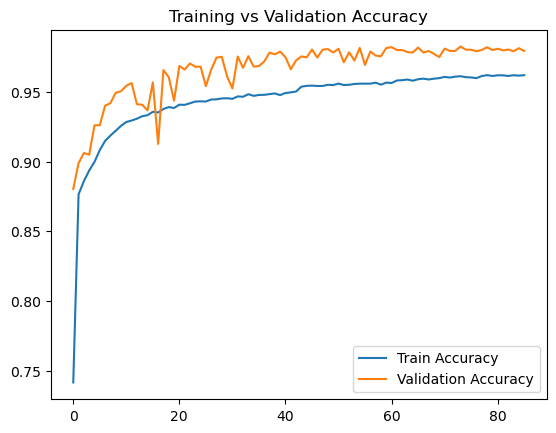

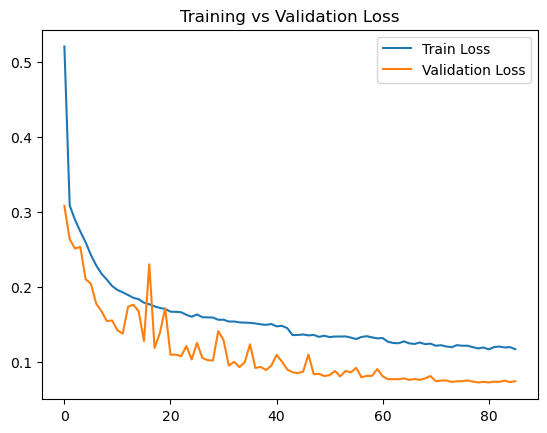

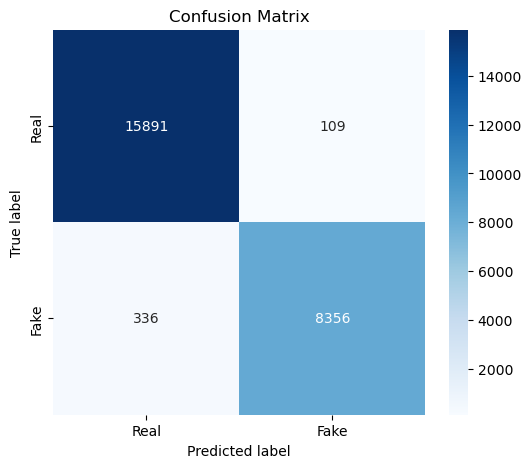

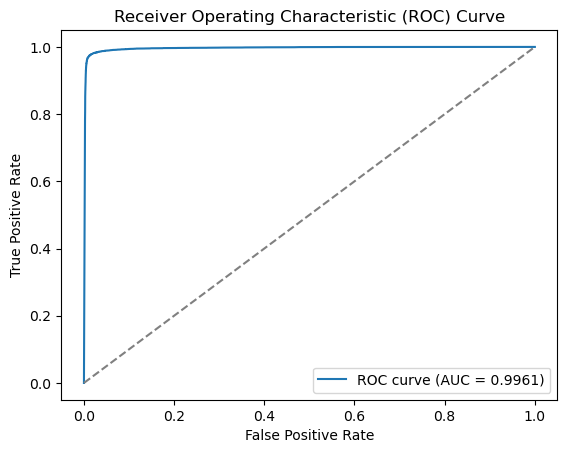

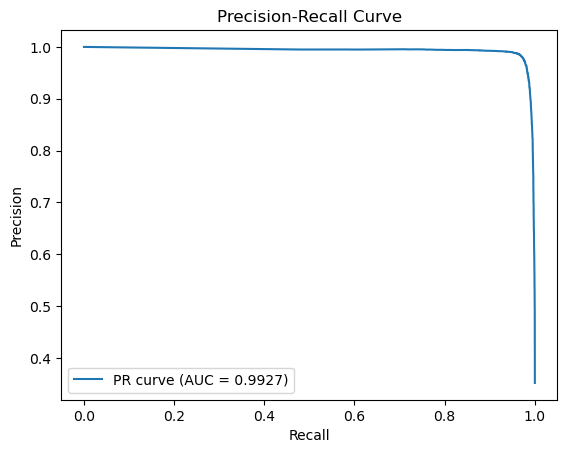

Accuracy Score: 0.9820
ROC AUC Score: 0.9961
Recall Score: 0.9613
Precision Score: 0.9871
F1 Score: 0.9741
PR AUC Score: 0.9927
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     16000
           1       0.99      0.96      0.97      8692

    accuracy                           0.98     24692
   macro avg       0.98      0.98      0.98     24692
weighted avg       0.98      0.98      0.98     24692



In [17]:
# Train the Model
train_model(spatial_model, temporal_model, x_train_seq, y_train, x_test_seq, y_test, epochs=100, batch_size=32)